In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
#pd.set_option('display.max_rows', None)

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month,while the test set is the 20th to the end of the month.
You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

### Read data

In [3]:
trdf = pd.read_csv('train.csv')
tedf = pd.read_csv('test.csv')
trdf.rename(columns={'count':'total number'},inplace=True);

In [4]:
trdf['datetime'] = pd.to_datetime(trdf['datetime']) 
tedf['datetime'] = pd.to_datetime(tedf['datetime'])
trdf.info()
print('-----------------------------------------------------------')
tedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      10886 non-null  datetime64[ns]
 1   season        10886 non-null  int64         
 2   holiday       10886 non-null  int64         
 3   workingday    10886 non-null  int64         
 4   weather       10886 non-null  int64         
 5   temp          10886 non-null  float64       
 6   atemp         10886 non-null  float64       
 7   humidity      10886 non-null  int64         
 8   windspeed     10886 non-null  float64       
 9   casual        10886 non-null  int64         
 10  registered    10886 non-null  int64         
 11  total number  10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
-----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entr

### import some important modules.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
trdf['total number'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: total number, dtype: float64

In [7]:
trdf['registered'].describe()

count    10886.000000
mean       155.552177
std        151.039033
min          0.000000
25%         36.000000
50%        118.000000
75%        222.000000
max        886.000000
Name: registered, dtype: float64

In [8]:
trdf['casual'].describe()

count    10886.000000
mean        36.021955
std         49.960477
min          0.000000
25%          4.000000
50%         17.000000
75%         49.000000
max        367.000000
Name: casual, dtype: float64

In [9]:
trdf.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total number
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### We cant use number in categorical varibale specially nomial vairable, becuase they dont have ratio and interval characteristics.

In [10]:
df=trdf.copy()
df['season'].replace(1, 'Spring',inplace=True)
df['season'].replace(2, 'Summer',inplace=True)
df['season'].replace(3, 'Fall',inplace=True)
df['season'].replace(4, 'Winter',inplace=True)

df['holiday'].replace(0, 'NotHoliday',inplace=True)
df['holiday'].replace(1, 'Holiday',inplace=True)

df['workingday'].replace(0, 'NotWorkingD',inplace=True)
df['workingday'].replace(1, 'WorkingD',inplace=True)

weather=['Clear','Little','Light_S_R','Heavy_S_R']
df['weather'].replace(1, weather[0],inplace=True)
df['weather'].replace(2, weather[1],inplace=True)
df['weather'].replace(3, weather[2],inplace=True)
df['weather'].replace(4, weather[3],inplace=True)
print('Converting numberic value of categorical column to string, this action need for dummying process.')
df.head()

Converting numberic value of categorical column to string, this action need for dummying process.


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total number
0,2011-01-01 00:00:00,Spring,NotHoliday,NotWorkingD,Clear,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,Spring,NotHoliday,NotWorkingD,Clear,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,Spring,NotHoliday,NotWorkingD,Clear,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,Spring,NotHoliday,NotWorkingD,Clear,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,Spring,NotHoliday,NotWorkingD,Clear,9.84,14.395,75,0.0,0,1,1


### Seperate year month day and hour, we can use them in the model.

In [11]:
df=df.assign(year=df.datetime.dt.year, month=df.datetime.dt.month, day=df.datetime.dt.day, hour=df.datetime.dt.hour)
df.drop('datetime',axis=1,inplace=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total number,year,month,day,hour
0,Spring,NotHoliday,NotWorkingD,Clear,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,Spring,NotHoliday,NotWorkingD,Clear,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,Spring,NotHoliday,NotWorkingD,Clear,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,Spring,NotHoliday,NotWorkingD,Clear,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,Spring,NotHoliday,NotWorkingD,Clear,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


### Dummying categirical variables, this process need before feeding to the model.

drop_first=True -> Delete some columns that are not helpful.\
For example holiday_Holiday column can explain holiday situation then dont need to holiday_NotHoliday column.

In [12]:
#Get k-1 dummies out of k categorical levels by removing the first level.
df_d = pd.get_dummies(df,drop_first=True)
df_d.head()

,temp,atemp,humidity,windspeed,casual,registered,total number,year,month,day,hour,season_Spring,season_Summer,season_Winter,holiday_NotHoliday,workingday_WorkingD,weather_Heavy_S_R,weather_Light_S_R,weather_Little
0,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,1,0,0,1,0,0,0,0
1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,1,0,0,1,0,0,0,0
2,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,1,0,0,1,0,0,0,0
3,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,1,0,0,1,0,0,0,0
4,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,1,0,0,1,0,0,0,0


In previous section (EDA section) we saw that temp and atemp are very high correlated.
I will not delete atemp but i will test it in linear regression.

In [13]:
# removing cacual. registered  columns.
df_d.drop(['casual','registered'],axis=1,inplace=True)
df_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temp                 10886 non-null  float64
 1   atemp                10886 non-null  float64
 2   humidity             10886 non-null  int64  
 3   windspeed            10886 non-null  float64
 4   total number         10886 non-null  int64  
 5   year                 10886 non-null  int64  
 6   month                10886 non-null  int64  
 7   day                  10886 non-null  int64  
 8   hour                 10886 non-null  int64  
 9   season_Spring        10886 non-null  uint8  
 10  season_Summer        10886 non-null  uint8  
 11  season_Winter        10886 non-null  uint8  
 12  holiday_NotHoliday   10886 non-null  uint8  
 13  workingday_WorkingD  10886 non-null  uint8  
 14  weather_Heavy_S_R    10886 non-null  uint8  
 15  weather_Light_S_R    10886 non-null 

We have count variable(total number) as response variable.\
For count variable suitable use posion regression but if response data become large range enough then maybe aother regression become helpful.\
I'm not sure that we can use ML regressor(like linear regression, randomforest regressor,svr, knn regressor etc) for count vairable, but i will use them for comparing.\
The first i use linear regression then random forest regressor and after that i will use possion regression too.

### Linear regression

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### spliting and shuffling the data

In [15]:
#seperate total number column as target variable.
totalNumber=df_d['total number']
df_d.drop('total number',axis=1,inplace=True)
x_train,x_test,y_train,y_test = train_test_split(df_d,totalNumber,test_size=0.25,random_state=42)
print('df_d.shape:',df_d.shape)
print('x_train.shape:',x_train.shape)
print('x_test.shape:',x_test.shape)
print('y_train.shape:',y_train.shape)
print('y_test.shape:',y_test.shape)
df_d.head()

df_d.shape: (10886, 16)
x_train.shape: (8164, 16)
x_test.shape: (2722, 16)
y_train.shape: (8164,)
y_test.shape: (2722,)


,temp,atemp,humidity,windspeed,year,month,day,hour,season_Spring,season_Summer,season_Winter,holiday_NotHoliday,workingday_WorkingD,weather_Heavy_S_R,weather_Light_S_R,weather_Little
0,9.84,14.395,81,0.0,2011,1,1,0,1,0,0,1,0,0,0,0
1,9.02,13.635,80,0.0,2011,1,1,1,1,0,0,1,0,0,0,0
2,9.02,13.635,80,0.0,2011,1,1,2,1,0,0,1,0,0,0,0
3,9.84,14.395,75,0.0,2011,1,1,3,1,0,0,1,0,0,0,0
4,9.84,14.395,75,0.0,2011,1,1,4,1,0,0,1,0,0,0,0


In [16]:
x_test.head()

,temp,atemp,humidity,windspeed,year,month,day,hour,season_Spring,season_Summer,season_Winter,holiday_NotHoliday,workingday_WorkingD,weather_Heavy_S_R,weather_Light_S_R,weather_Little
3133,33.62,40.150,59,0.0000,2011,7,19,11,0,0,0,1,1,0,0,0
5786,4.10,6.820,54,6.0032,2012,1,16,6,1,0,0,0,0,0,0,0
5224,9.84,11.365,48,12.9980,2011,12,11,18,0,0,1,1,0,0,0,0
8953,29.52,34.090,62,12.9980,2012,8,15,10,0,0,0,1,1,0,0,1
8054,25.42,31.060,53,16.9979,2012,6,15,23,0,1,0,1,1,0,0,0


In [17]:
x_train.head()

,temp,atemp,humidity,windspeed,year,month,day,hour,season_Spring,season_Summer,season_Winter,holiday_NotHoliday,workingday_WorkingD,weather_Heavy_S_R,weather_Light_S_R,weather_Little
2930,28.70,32.575,65,12.9980,2011,7,11,0,0,0,0,1,1,0,0,0
7669,22.96,26.515,52,22.0028,2012,5,18,22,0,1,0,1,1,0,0,0
1346,12.30,15.910,61,6.0032,2011,4,1,23,0,1,0,1,1,0,0,0
9432,23.78,27.275,60,8.9981,2012,9,16,9,0,0,0,1,0,0,0,0
453,8.20,9.850,93,12.9980,2011,2,1,23,1,0,0,1,1,0,1,0


In [18]:
totalNumber[:10]

0    16
1    40
2    32
3    13
4     1
5     1
6     2
7     3
8     8
9    14
Name: total number, dtype: int64

### Scaling data
I use two scaling method: Normalization and standadization

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [20]:
numerical_ix = x_train.select_dtypes(include=['int64', 'float64']).columns
ct_norm   = ColumnTransformer(transformers=[('minmax', MinMaxScaler(), numerical_ix)], remainder='passthrough')
ct_standr = ColumnTransformer(transformers=[('standr', StandardScaler(), numerical_ix)], remainder='passthrough')
numerical_ix

Index(['temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day',
       'hour'],
      dtype='object')

### Linear regression with and without scaling

In [21]:
#create model
from sklearn.pipeline import Pipeline
MLregModel = LinearRegression()
pipeline_norm = Pipeline(steps=[('ct_norm',ct_norm),('model',MLregModel)])
pipeline_standr = Pipeline(steps=[('ct_standr',ct_standr),('model',MLregModel)])

### creating a function for fitting and evaluating the models.

In [22]:
def fit_eval_model(model, x_train, y_train, x_test, y_test, metricList):
    m = model
    m.fit(x_train,y_train)
    y_train_pred = m.predict(x_train)
    y_test_pred = m.predict(x_test)
    metricDataframe =pd.DataFrame()
    for name,metric in metricList:
        metricDataframe[name+'_train'] = [round(metric(y_train,y_train_pred),3)]
        metricDataframe[name+'_test'] = [round(metric(y_test,y_test_pred),3)]
    return metricDataframe,y_train_pred,y_test_pred,m

### Fitting model(Linear regression) and test it without scaling.

In [247]:
metricList = [('r2_score',r2_score),('MSE',mean_squared_error)]
LRNoScaling_result = fit_eval_model(LinearRegression(),x_train, y_train, x_test, y_test, metricList)
LRNoScaling_result[0]

,r2_score_train,r2_score_test,MSE_train,MSE_test
0,0.399,0.391,19721.937,19970.654


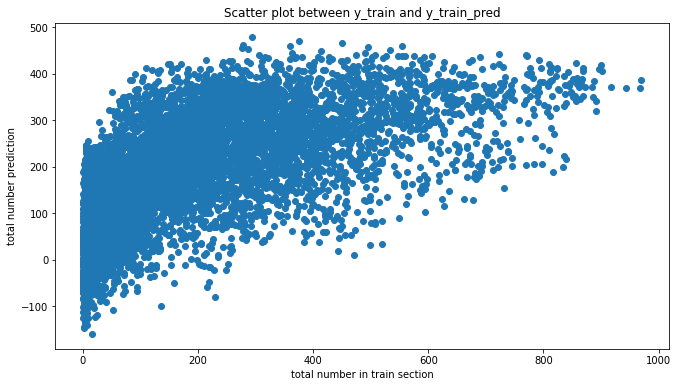

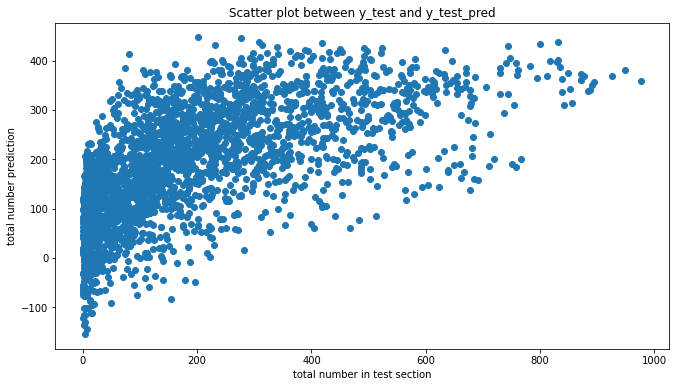

In [248]:
plt.figure(figsize=(11,6))
plt.scatter(y_train,LRNoScaling_result[1])
ax = plt.gca()
ax.set(title='Scatter plot between y_train and y_train_pred')
ax.set_xlabel('total number in train section')
ax.set_ylabel('total number prediction');

plt.figure(figsize=(11,6))
plt.scatter(y_test,LRNoScaling_result[2])
ax = plt.gca()
ax.set(title='Scatter plot between y_test and y_test_pred')
ax.set_xlabel('total number in test section')
ax.set_ylabel('total number prediction');



LR model without scaling made awful prediction.

### Fitting model(Linear regression) and test it with scaling (MinMaxScaler).

In [246]:

LRScaled_norm_result= fit_eval_model(pipeline_norm,x_train, y_train, x_test, y_test, metricList)
LRScaled_norm_result[0]

,r2_score_train,r2_score_test,MSE_train,MSE_test
0,0.399,0.391,19721.937,19970.654


In [249]:

LRScaled_standr_result = fit_eval_model(pipeline_standr,x_train, y_train, x_test, y_test, metricList)
LRScaled_standr_result[0]

,r2_score_train,r2_score_test,MSE_train,MSE_test
0,0.399,0.391,19721.937,19970.654


Unfortunately, the above models are no different.

### ### use 'Polynomial trnasformation' to create complex LR model.

In [297]:
pipeline_poly = Pipeline(steps=[('poly',PolynomialFeatures(degree=3  )),('model',LinearRegression() )])

PolyLR_result = fit_eval_model(pipeline_poly,x_train, y_train, x_test, y_test, metricList)
PolyLR_result[0]

,r2_score_train,r2_score_test,MSE_train,MSE_test
0,0.676,0.619,10617.415,12499.896


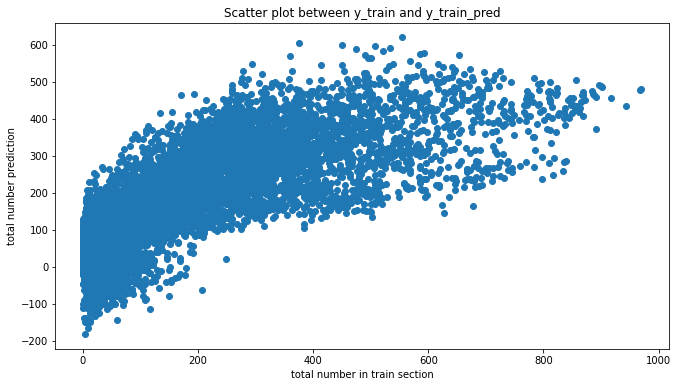

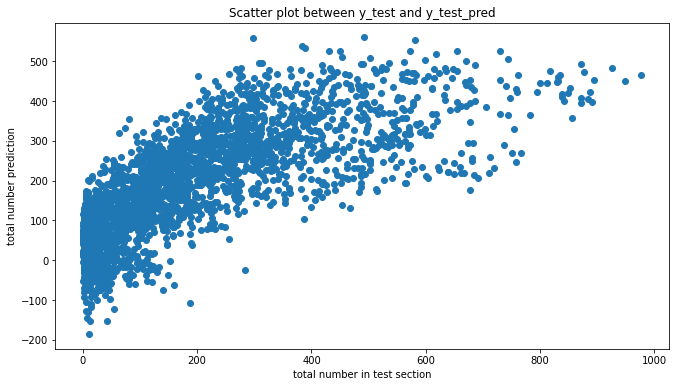

In [262]:
plt.figure(figsize=(11,6))
plt.scatter(y_train,PolyLR_result[1])
ax = plt.gca()
ax.set(title='Scatter plot between y_train and y_train_pred')
ax.set_xlabel('total number in train section')
ax.set_ylabel('total number prediction');

plt.figure(figsize=(11,6))
plt.scatter(y_test,PolyLR_result[2])
ax = plt.gca()
ax.set(title='Scatter plot between y_test and y_test_pred')
ax.set_xlabel('total number in test section')
ax.set_ylabel('total number prediction');

the complex model by Polynomial trnasformation degree=2 help to beter fit.
but scatter plot show that some prediction is negative sign that is not good.

### I will combine Ridge or lasso regression with polynomial to close test and train MSE.

In [260]:
from sklearn.linear_model import Ridge,Lasso

In [288]:
pipeline_polyRidge = Pipeline(steps=[('ct_standr',ct_standr),('poly',PolynomialFeatures(degree=3  )),('model',Ridge(alpha=100) )])
polyRidgeLR_result = fit_eval_model(pipeline_polyRidge,x_train, y_train, x_test, y_test, metricList)
polyRidgeLR_result[0]

,r2_score_train,r2_score_test,MSE_train,MSE_test
0,0.657,0.626,11262.553,12268.092


In [295]:
pipeline_polyLasso = Pipeline(steps=[('ct_standr',ct_standr),('poly',PolynomialFeatures(degree=3  )),('model',Lasso(alpha=0.001) )])
polyLassoLR_result = fit_eval_model(pipeline_polyRidge,x_train, y_train, x_test, y_test, metricList)
polyLassoLR_result[0]

,r2_score_train,r2_score_test,MSE_train,MSE_test
0,0.657,0.626,11262.553,12268.092


### RandomForestRegressor

In [298]:
from sklearn.ensemble import RandomForestRegressor

In [549]:
randomForestR1_result = fit_eval_model(RandomForestRegressor(random_state=0,criterion='squared_error'),
                                       x_train, y_train, x_test, y_test, metricList)
randomForestR1_result[0]

,r2_score_train,r2_score_test,MSE_train,MSE_test,MPD_train,MPD_test
0,0.992,0.947,272.919,1746.501,1.391,8.278


In [550]:
randomForestR2_result = fit_eval_model(RandomForestRegressor(n_estimators=100,random_state=0,criterion='poisson')
                                       ,x_train, y_train, x_test, y_test, metricList)
randomForestR2_result[0]

,r2_score_train,r2_score_test,MSE_train,MSE_test,MPD_train,MPD_test
0,0.992,0.945,275.934,1793.804,1.365,8.433


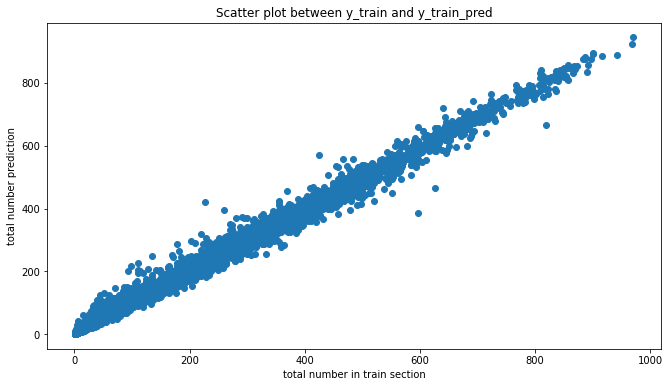

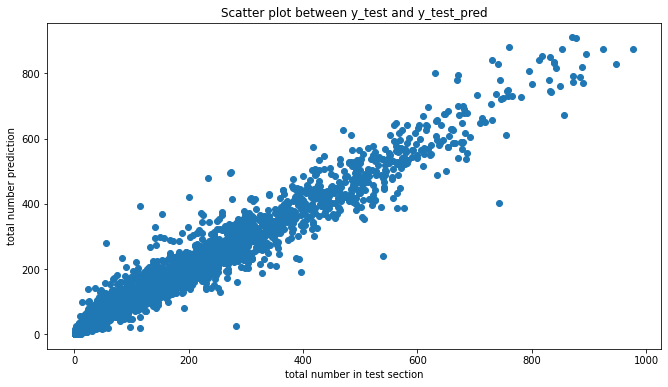

In [303]:
plt.figure(figsize=(11,6))
plt.scatter(y_train,randomForestR1_result[1])
ax = plt.gca()
ax.set(title='Scatter plot between y_train and y_train_pred')
ax.set_xlabel('total number in train section')
ax.set_ylabel('total number prediction');

plt.figure(figsize=(11,6))
plt.scatter(y_test,randomForestR1_result[2])
ax = plt.gca()
ax.set(title='Scatter plot between y_test and y_test_pred')
ax.set_xlabel('total number in test section')
ax.set_ylabel('total number prediction');

In [335]:
from scipy.stats import spearmanr
spearmanr(randomForestR1_result[1],y_train)

SpearmanrResult(correlation=0.9960257895556249, pvalue=0.0)

In [336]:
spearmanr(randomForestR1_result[2],y_test)

SpearmanrResult(correlation=0.9745509580390956, pvalue=0.0)

These two RandomForestRegressor are better than previous regressors, but pay attention to 'MSE'? It is a sign of over-fitting.\
I should regulate some hyperparameters to test's and train's "MSE" become close together,where the model trained generalize better in test data.\
I will use RandomizedSearchCV. Due to hardware limitations, I put the range of hyperparameters in a low range.

In [394]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

In [465]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
model = RandomForestRegressor()
params = dict()
params['n_estimators']=[2,5,10,30,100,200]
params['max_depth'] = [1,2,5,10,20,None]
params['min_samples_split']=[2,5,10,20,50,100]
params['min_samples_leaf']=[1,2,5,10,20,50,100]
params['max_features']=[1,2,5,10,20,50,100]
params['criterion']=['squared_error','poisson']
scoring = ['r2','neg_mean_squared_error','neg_mean_absolute_error','neg_mean_poisson_deviance']

In [468]:
search = RandomizedSearchCV(model, params, n_iter=20, scoring=scoring, n_jobs=-1, cv=cv,
                            random_state=1,return_train_score=True,refit='neg_mean_squared_error')

In [469]:
result = search.fit(df_d, totalNumber)

In [470]:
result.scorer_

{'r2': make_scorer(r2_score),
 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
 'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
 'neg_mean_poisson_deviance': make_scorer(mean_poisson_deviance, greater_is_better=False)}

In [471]:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -2545.6983940003743
Best Hyperparameters: {'n_estimators': 10, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 50, 'max_depth': 20, 'criterion': 'squared_error'}


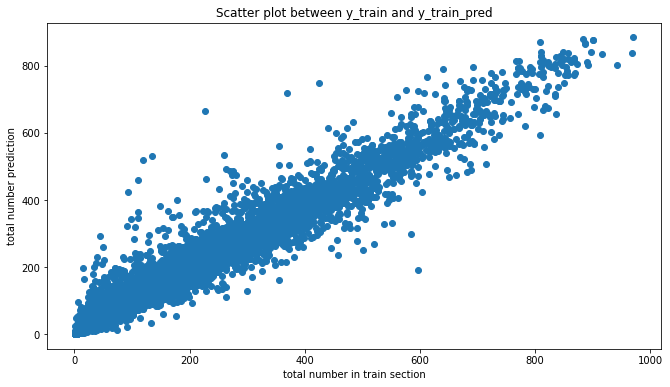

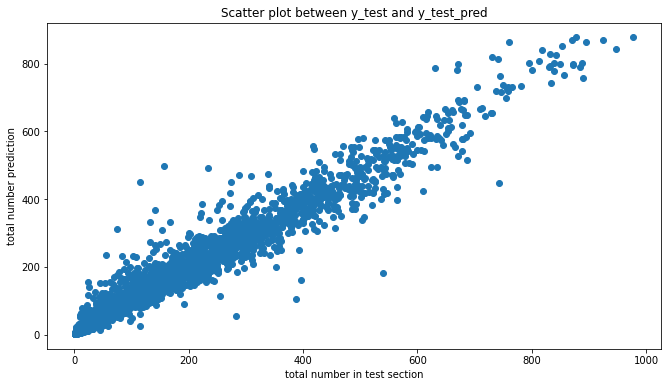

In [480]:
plt.figure(figsize=(11,6))
plt.scatter(y_train,result.predict(x_train))
ax = plt.gca()
ax.set(title='Scatter plot between y_train and y_train_pred')
ax.set_xlabel('total number in train section')
ax.set_ylabel('total number prediction');

plt.figure(figsize=(11,6))
plt.scatter(y_test,result.predict(x_test))
ax = plt.gca()
ax.set(title='Scatter plot between y_test and y_test_pred')
ax.set_xlabel('total number in test section')
ax.set_ylabel('total number prediction');

In [472]:
cv_resultsDf_RF=pd.DataFrame(result.cv_results_)
print(cv_resultsDf_RF.shape)
cv_resultsDf_RF.head()

(20, 151)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,split5_test_r2,split6_test_r2,split7_test_r2,split8_test_r2,split9_test_r2,split10_test_r2,split11_test_r2,split12_test_r2,split13_test_r2,split14_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,split5_train_r2,split6_train_r2,split7_train_r2,split8_train_r2,split9_train_r2,split10_train_r2,split11_train_r2,split12_train_r2,split13_train_r2,split14_train_r2,mean_train_r2,std_train_r2,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,split5_test_neg_mean_squared_error,split6_test_neg_mean_squared_error,split7_test_neg_mean_squared_error,split8_test_neg_mean_squared_error,split9_test_neg_mean_squared_error,split10_test_neg_mean_squared_error,split11_test_neg_mean_squared_error,split12_test_neg_mean_squared_error,split13_test_neg_mean_squared_error,split14_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_train_neg_mean_squared_error,split1_train_neg_mean_squared_error,split2_train_neg_mean_squared_error,split3_train_neg_mean_squared_error,split4_train_neg_mean_squared_error,split5_train_neg_mean_squared_error,split6_train_neg_mean_squared_error,split7_train_neg_mean_squared_error,split8_train_neg_mean_squared_error,split9_train_neg_mean_squared_error,split10_train_neg_mean_squared_error,split11_train_neg_mean_squared_error,split12_train_neg_mean_squared_error,split13_train_neg_mean_squared_error,split14_train_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,split5_test_neg_mean_absolute_error,split6_test_neg_mean_absolute_error,split7_test_neg_mean_absolute_error,split8_test_neg_mean_absolute_error,split9_test_neg_mean_absolute_error,split10_test_neg_mean_absolute_error,split11_test_neg_mean_absolute_error,split12_test_neg_mean_absolute_error,split13_test_neg_mean_absolute_error,split14_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,split5_train_neg_mean_absolute_error,split6_train_neg_mean_absolute_error,split7_train_neg_mean_absolute_error,split8_train_neg_mean_absolute_error,split9_train_neg_mean_absolute_error,split10_train_neg_mean_absolute_error,split11_train_neg_mean_absolute_error,split12_train_neg_mean_absolute_error,split13_train_neg_mean_absolute_error,split14_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error,split0_test_neg_mean_poisson_deviance,split1_test_neg_mean_poisson_deviance,split2_test_neg_mean_poisson_deviance,split3_test_neg_mean_poisson_deviance,split4_test_neg_mean_poisson_deviance,split5_test_neg_mean_poisson_deviance,split6_test_neg_mean_poisson_deviance,split7_test_neg_mean_poisson_deviance,split8_test_neg_mean_poisson_deviance,split9_test_neg_mean_poisson_deviance,split10_test_neg_mean_poisson_deviance,split11_test_neg_mean_poisson_deviance,split12_test_neg_mean_poisson_deviance,split13_test_neg_mean_poisson_deviance,split14_test_neg_mean_poisson_deviance,mean_test_neg_mean_poisson_deviance,std_test_neg_mean_poisson_deviance,rank_test_neg_mean_poisson_deviance,split0_train_neg_mean_poisson_deviance,split1_train_neg_mean_poisson_deviance,sp

In [454]:
cv_resultsDf_RF.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'param_min_samples_split',
       'param_min_samples_leaf', 'param_max_features', 'param_max_depth',
       'param_criterion',
       ...
       'split7_train_neg_mean_poisson_deviance',
       'split8_train_neg_mean_poisson_deviance',
       'split9_train_neg_mean_poisson_deviance',
       'split10_train_neg_mean_poisson_deviance',
       'split11_train_neg_mean_poisson_deviance',
       'split12_train_neg_mean_poisson_deviance',
       'split13_train_neg_mean_poisson_deviance',
       'split14_train_neg_mean_poisson_deviance',
       'mean_train_neg_mean_poisson_deviance',
       'std_train_neg_mean_poisson_deviance'],
      dtype='object', length=151)

In [473]:
filter_col = [col for col in cv_resultsDf_RF.columns if col.startswith('mean')]
filter_col

['mean_fit_time',
 'mean_score_time',
 'mean_test_r2',
 'mean_train_r2',
 'mean_test_neg_mean_squared_error',
 'mean_train_neg_mean_squared_error',
 'mean_test_neg_mean_absolute_error',
 'mean_train_neg_mean_absolute_error',
 'mean_test_neg_mean_poisson_deviance',
 'mean_train_neg_mean_poisson_deviance']

In [474]:
scoreDF_RF = cv_resultsDf_RF[filter_col[2:]]
scoreDF_RF

,mean_test_r2,mean_train_r2,mean_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,mean_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,mean_test_neg_mean_poisson_deviance,mean_train_neg_mean_poisson_deviance
0,0.111361,0.110978,-29137.503755,-29170.473350,-132.866156,-132.951920,-145.545639,-145.705375
1,0.311698,0.312180,-22574.192927,-22567.025815,-106.975926,-106.954985,-93.098673,-93.062966
2,0.664414,0.669786,-10999.703465,-10834.223338,-68.961697,-68.322877,-40.174685,-39.462668
3,0.899149,0.913207,-3306.444548,-2847.143473,-37.066338,-34.442156,-14.612126,-12.628655
4,0.155351,0.156760,-27700.410815,-27667.294075,-129.178519,-129.096225,-138.566054,-138.398502
5,0.920299,0.981044,-2610.556505,-621.794314,-32.415606,-13.961016,-11.727321,-2.899104
6,0.916598,0.939018,-2734.248630,-2000.483429,-32.879519,-28.072062,-12.206791,-9.097452
7,0.091537,0.091386,-29764.749490,-29819.257582,-134.094541,-134.193926,-148.651674,-148.909085
8,0.852938,0.863347,-4822.142153,-4482.577948,-45.427280,-43.837244,-20.705097,-19.366120
9,0.479669,0.499348,-17067.843662,-16423.675686,-94.047399,-92.372426,-78.089219,-75.454850


In [479]:
scoreDF_RF[scoreDF_RF.mean_test_neg_mean_squared_error==scoreDF_RF.mean_test_neg_mean_squared_error.max()]

,mean_test_r2,mean_train_r2,mean_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,mean_test_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,mean_test_neg_mean_poisson_deviance,mean_train_neg_mean_poisson_deviance
16,0.922312,0.942824,-2545.698394,-1875.782156,-31.632099,-27.161371,-11.422716,-8.561659


Sounds like a good result.\
It should be noted that there are other models, but we will suffice with just a few models and assign the last model to the Poisson model.

### Poisson regression
For this goal there are many packages and classes that support this type of regression.\
In addition, we can use common regressors like linear regression (depending on what our evaluation criteria are).\
The following packages and classes also have Poisson criteria.\
- sklearn -> RandomForestRegressor
- sklearn -> HistGradientBoostingRegressor
- statsmodels -> statsmodels.api.GLM  (Generalized Linear Models)
- xgboost -> XGBRegressor 

In [506]:
from sklearn import linear_model
from sklearn.metrics import mean_poisson_deviance


In [523]:
metricList = [('r2_score',r2_score),('MSE',mean_squared_error),('MPD',mean_poisson_deviance)]

poissonModel=linear_model.PoissonRegressor(max_iter=100)
pipeline_polyPoissonR = Pipeline(steps=[('ct_norm',ct_norm),('poly',PolynomialFeatures(degree=1  )),('model',poissonModel )])

polyPoissonR_result = fit_eval_model(pipeline_polyPoissonR,x_train, y_train, x_test, y_test, metricList)
polyPoissonR_result[0]

,r2_score_train,r2_score_test,MSE_train,MSE_test,MPD_train,MPD_test
0,0.404,0.397,19563.939,19795.01,94.435,94.038


In [524]:
poissonModel=linear_model.PoissonRegressor(max_iter=200)
pipeline_polyPoissonR = Pipeline(steps=[('ct_norm',ct_norm),('poly',PolynomialFeatures(degree=2  )),('model',poissonModel )])

polyPoissonR_result = fit_eval_model(pipeline_polyPoissonR,x_train, y_train, x_test, y_test, metricList)
polyPoissonR_result[0]

,r2_score_train,r2_score_test,MSE_train,MSE_test,MPD_train,MPD_test
0,0.521,0.512,15704.366,16029.287,74.64,75.159


In [526]:
poissonModel=linear_model.PoissonRegressor(max_iter=400)
pipeline_polyPoissonR = Pipeline(steps=[('ct_norm',ct_norm),('poly',PolynomialFeatures(degree=3  )),('model',poissonModel )])

polyPoissonR_result = fit_eval_model(pipeline_polyPoissonR,x_train, y_train, x_test, y_test, metricList)
polyPoissonR_result[0]

,r2_score_train,r2_score_test,MSE_train,MSE_test,MPD_train,MPD_test
0,0.614,0.594,12680.007,13337.225,59.026,61.234


Well, it seems enough and we are content with the same random forest model.\
Now we pre-process the kaggle test data and make the prediction.

In [527]:
tedf.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### Read sampleSubmission.csv and use it to save resualts.

In [537]:
resultForSub = pd.read_csv('sampleSubmission.csv')
print('resultForSub.shape: ',resultForSub.shape)
print('test data shape: ',tedf.shape)
resultForSub.head()

resultForSub.shape:  (6493, 2)
test data shape:  (6493, 9)


,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


### Convert categorical number to string

In [531]:
df=tedf.copy()
df['season'].replace(1, 'Spring',inplace=True)
df['season'].replace(2, 'Summer',inplace=True)
df['season'].replace(3, 'Fall',inplace=True)
df['season'].replace(4, 'Winter',inplace=True)

df['holiday'].replace(0, 'NotHoliday',inplace=True)
df['holiday'].replace(1, 'Holiday',inplace=True)

df['workingday'].replace(0, 'NotWorkingD',inplace=True)
df['workingday'].replace(1, 'WorkingD',inplace=True)

weather=['Clear','Little','Light_S_R','Heavy_S_R']
df['weather'].replace(1, weather[0],inplace=True)
df['weather'].replace(2, weather[1],inplace=True)
df['weather'].replace(3, weather[2],inplace=True)
df['weather'].replace(4, weather[3],inplace=True)
print('Converting numberic value of categorical column to string, this action need for dummying process.')
df.head()

Converting numberic value of categorical column to string, this action need for dummying process.


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,Spring,NotHoliday,WorkingD,Clear,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,Spring,NotHoliday,WorkingD,Clear,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,Spring,NotHoliday,WorkingD,Clear,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,Spring,NotHoliday,WorkingD,Clear,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,Spring,NotHoliday,WorkingD,Clear,10.66,12.880,56,11.0014


### Seperate year month day and hour, we can use them in the model.

In [532]:
df=df.assign(year=df.datetime.dt.year, month=df.datetime.dt.month, day=df.datetime.dt.day, hour=df.datetime.dt.hour)
df.drop('datetime',axis=1,inplace=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,Spring,NotHoliday,WorkingD,Clear,10.66,11.365,56,26.0027,2011,1,20,0
1,Spring,NotHoliday,WorkingD,Clear,10.66,13.635,56,0.0000,2011,1,20,1
2,Spring,NotHoliday,WorkingD,Clear,10.66,13.635,56,0.0000,2011,1,20,2
3,Spring,NotHoliday,WorkingD,Clear,10.66,12.880,56,11.0014,2011,1,20,3
4,Spring,NotHoliday,WorkingD,Clear,10.66,12.880,56,11.0014,2011,1,20,4


### Dummying categirical variables, this process need before feeding to the model.

drop_first=True -> Delete some columns that are not helpful.\
For example holiday_Holiday column can explain holiday situation then dont need to holiday_NotHoliday column.

In [533]:
#Get k-1 dummies out of k categorical levels by removing the first level.
df_dte = pd.get_dummies(df,drop_first=True)
df_dte.head()

,temp,atemp,humidity,windspeed,year,month,day,hour,season_Spring,season_Summer,season_Winter,holiday_NotHoliday,workingday_WorkingD,weather_Heavy_S_R,weather_Light_S_R,weather_Little
0,10.66,11.365,56,26.0027,2011,1,20,0,1,0,0,1,1,0,0,0
1,10.66,13.635,56,0.0000,2011,1,20,1,1,0,0,1,1,0,0,0
2,10.66,13.635,56,0.0000,2011,1,20,2,1,0,0,1,1,0,0,0
3,10.66,12.880,56,11.0014,2011,1,20,3,1,0,0,1,1,0,0,0
4,10.66,12.880,56,11.0014,2011,1,20,4,1,0,0,1,1,0,0,0


In [534]:
df_dte.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temp                 6493 non-null   float64
 1   atemp                6493 non-null   float64
 2   humidity             6493 non-null   int64  
 3   windspeed            6493 non-null   float64
 4   year                 6493 non-null   int64  
 5   month                6493 non-null   int64  
 6   day                  6493 non-null   int64  
 7   hour                 6493 non-null   int64  
 8   season_Spring        6493 non-null   uint8  
 9   season_Summer        6493 non-null   uint8  
 10  season_Winter        6493 non-null   uint8  
 11  holiday_NotHoliday   6493 non-null   uint8  
 12  workingday_WorkingD  6493 non-null   uint8  
 13  weather_Heavy_S_R    6493 non-null   uint8  
 14  weather_Light_S_R    6493 non-null   uint8  
 15  weather_Little       6493 non-null   u

In [538]:
countPrediction = result.predict(df_dte)

In [539]:
countPrediction.shape

(6493,)

In [540]:
resultForSub['count'] = countPrediction
resultForSub.head()

,datetime,count
0,2011-01-20 00:00:00,12.563916
1,2011-01-20 01:00:00,6.477308
2,2011-01-20 02:00:00,3.829858
3,2011-01-20 03:00:00,3.432510
4,2011-01-20 04:00:00,2.793509


In [546]:
resultForSub.set_index('datetime',inplace=True)
resultForSub.head()

,count
datetime,
2011-01-20 00:00:00,12.563916
2011-01-20 01:00:00,6.477308
2011-01-20 02:00:00,3.829858
2011-01-20 03:00:00,3.432510
2011-01-20 04:00:00,2.793509


In [547]:
file_name = 'PredictionTestData_result.csv'
resultForSub.to_csv(file_name)

I will use another RandomForest regressor that the first made it.It name was randomForestR1_result

In [552]:
countPrediction2 = randomForestR1_result[3].predict(df_dte)
countPrediction2.shape

(6493,)

In [553]:
resultForSub2 = pd.read_csv('sampleSubmission.csv')
resultForSub2['count'] = countPrediction2
resultForSub2.set_index('datetime',inplace=True)
resultForSub2.head()

,count
datetime,
2011-01-20 00:00:00,14.42
2011-01-20 01:00:00,7.06
2011-01-20 02:00:00,5.65
2011-01-20 03:00:00,3.31
2011-01-20 04:00:00,2.49


In [554]:
file_name = 'PredictionTestData_result2.csv'
resultForSub2.to_csv(file_name)

Kaggle gave the first model a better score.

<img src="./scoreSubmission.png">